# Fine-tuning BERT for NER on Video Comments

In this notebook, we will:

1. Load video comment data from a CSV file.
2. Preprocess the data and align token-level labels.
3. Fine-tune a pre-trained BERT model (using Hugging Face Transformers) for Named Entity Recognition.
4. Evaluate the model.

### Baseline Model: BERT-NER

This notebook implements a baseline Named Entity Recognition (NER) model using a fine-tuned BERT architecture. It serves as the foundation for evaluating improvements introduced by contextual embeddings and clustering methods in our final pipeline.

We evaluate the model using standard NER metrics (precision, recall, F1-score) on a held-out test set.

In [1]:
!pip3 install transformers seqeval torch "accelerate>=0.26.0"
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 80.6 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
if not hasattr(torch, "get_default_device"):
    torch.get_default_device = lambda: torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AutoModelForTokenClassification,
                          TrainingArguments, Trainer, DataCollatorForTokenClassification)
from sklearn.model_selection import train_test_split
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import ast
from collections import Counter
import spacy
from sklearn.model_selection import train_test_split
from datetime import datetime
import random
import re

In [3]:
# Import the dataset
nlp = spacy.load("en_core_web_sm")
df = pd.read_csv('../data/4698969/Dataset_updated.csv')
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.head()

,ID,Date,Author,Likes,Replies,Comment,Relevance,Polarity,Feature request,Problem report,Efficiency,Safety,tokens,labels,num_tokens,has_entity,entity_tokens,combined_labels_str
0,UghhPYDEB6B173gCoAEC,2017-04-28T18:12:45Z,Aaron Brown,1679,30,i want what he's smoking,spam,neutral,False,False,False,false,"['i', 'want', 'what', 'he', ""'s"", 'smoking']","['spam', 'neutral', False, False, False, 'false']",6,True,"['i', 'want', 'what', 'he', ""'s"", 'smoking']","False, False, False, false, neutral, spam"
1,Ugh6WAPQinruAHgCoAEC,2017-04-28T18:15:14Z,Felician Cadar,684,22,I love how Musk always makes seemingly wild cl...,spam,positive,False,False,False,false,"['I', 'love', 'how', 'Musk', 'always', 'makes'...","['spam', 'positive', False, False, False, 'fal...",23,True,"['I', 'love', 'how', 'Musk', 'always', 'makes']","False, False, False, false, positive, spam"
2,Ugj9xobHmVeDEHgCoAEC,2017-04-28T18:24:53Z,Kelvin Yang,0,0,No.3,spam,neutral,False,False,False,false,['No.3'],"['spam', 'neutral', False, False, False, 'false']",1,True,['No.3'],"False, False, False, false, neutral, spam"
3,Ugj39PRg5dVn8XgCoAEC,2017-04-28T18:25:31Z,Kelvin Yang,140,4,Could be the start of a historical company,spam,neutral,False,False,False,false,"['Could', 'be', 'the', 'start', 'of', 'a', 'hi...","['spam', 'neutral', False, False, False, 'false']",8,True,"['Could', 'be', 'the', 'start', 'of', 'a']","False, False, False, false, neutral, spam"
4,Ugiu9jMmiWts1HgCoAEC,2017-04-28T18:31:52Z,serendipity42,675,9,Gotta start somewhere before making tunnels on...,spam,neutral,False,False,False,false,"['Got', 'ta', 'start', 'somewhere', 'before', ...","['spam', 'neutral', False, False, False, 'false']",9,True,"['Got', 'ta', 'start', 'somewhere', 'before', ...","False, False, False, false, neutral, spam"


In [4]:
print("Dataset shape:", df.shape)
print("Columns:", df.columns)

Dataset shape: (4275, 18)
Columns: Index(['ID', 'Date', 'Author', 'Likes', 'Replies', 'Comment', 'Relevance',
       'Polarity', 'Feature request', 'Problem report', 'Efficiency', 'Safety',
       'tokens', 'labels', 'num_tokens', 'has_entity', 'entity_tokens',
       'combined_labels_str'],
      dtype='object')


---

## Data Format Assumptions

For this notebook we assume:

- **Comment:** contains the raw comment text.
- **combined_labels_str:** contains a string representation of a list of token-level BIO labels (aligned to a whitespace tokenization of the comment).

## Building the Label Set

We scan through the dataset to extract all unique labels from the combined_labels_str column.

In [5]:
# Extract named entities from comments
comment_entities = []
for text in df['Comment'].dropna():
    doc = nlp(text)
    for ent in doc.ents:
        comment_entities.append((ent.text.strip(), ent.label_))

entity_df = pd.DataFrame(comment_entities, columns=["Entity", "Label"])

# Expand entity coverage: PERSON, ORG, PRODUCT, GPE, EVENT, WORK_OF_ART
included_labels = ["PERSON", "ORG", "PRODUCT", "GPE", "EVENT", "WORK_OF_ART"]
entity_df = entity_df[entity_df["Label"].isin(included_labels)]

In [6]:
# Create lowercase keyword sets
entity_keywords = {
    "B-PER": set(entity_df[entity_df["Label"] == "PERSON"]["Entity"].str.lower()),
    "B-ORG": set(entity_df[entity_df["Label"] == "ORG"]["Entity"].str.lower()),
    "B-PROD": set(entity_df[entity_df["Label"] == "PRODUCT"]["Entity"].str.lower()),
    "B-LOC": set(entity_df[entity_df["Label"] == "GPE"]["Entity"].str.lower()),
    "B-EVENT": set(entity_df[entity_df["Label"] == "EVENT"]["Entity"].str.lower()),
    "B-WORK": set(entity_df[entity_df["Label"] == "WORK_OF_ART"]["Entity"].str.lower()),
}

In [7]:
# --- Function to assign BIO-style labels ---
def clean_token(token):
    return re.sub(r'[^\w\s]', '', token.lower())

# Function to assign synthetic labels using these keyword sets
def generate_synthetic_labels(tokens):
    labels = []
    for token in tokens:
        clean = clean_token(token)
        tag = "O"
        for label_prefix, keywords in entity_keywords.items():
            if clean in keywords:
                tag = label_prefix
                break
        labels.append(tag)
    return labels

# Remove samples where all labels are "O"
def is_all_O(label_seq):
    return all(tag == "O" for tag in label_seq)

In [8]:
# Apply label generation
df["synthetic_labels"] = df["tokens"].apply(generate_synthetic_labels)

# Filter
filtered_df = df[~df["synthetic_labels"].apply(is_all_O)].reset_index(drop=True)

# Update texts and labels
texts = filtered_df["tokens"].tolist()
labels = filtered_df["synthetic_labels"].tolist()

# Save the final data for training
texts = df["tokens"].tolist()
labels = df["synthetic_labels"].tolist()

In [ ]:
# Filter out examples where all labels are "O"
def contains_named_entity(seq):
    return any(tag != "O" for tag in seq)

filtered = [(x, y) for x, y in zip(texts, labels) if contains_named_entity(y)]
texts, labels = zip(*filtered)
texts, labels = list(texts), list(labels)  # re-wrap as lists

In [9]:
# Quick check
print("Example:", list(zip(texts[0], labels[0])))
flat = [tag for seq in labels for tag in seq]
print(Counter(flat))

Example: [('[', 'O'), ("'", 'O'), ('i', 'O'), ("'", 'O'), (',', 'O'), (' ', 'O'), ("'", 'O'), ('w', 'O'), ('a', 'O'), ('n', 'O'), ('t', 'O'), ("'", 'O'), (',', 'O'), (' ', 'O'), ("'", 'O'), ('w', 'O'), ('h', 'O'), ('a', 'O'), ('t', 'O'), ("'", 'O'), (',', 'O'), (' ', 'O'), ("'", 'O'), ('h', 'O'), ('e', 'O'), ("'", 'O'), (',', 'O'), (' ', 'O'), ('"', 'O'), ("'", 'O'), ('s', 'B-ORG'), ('"', 'O'), (',', 'O'), (' ', 'O'), ("'", 'O'), ('s', 'B-ORG'), ('m', 'O'), ('o', 'O'), ('k', 'O'), ('i', 'O'), ('n', 'O'), ('g', 'O'), ("'", 'O'), (']', 'O')]
Counter({'O': 592320, 'B-ORG': 19275, 'B-PROD': 5700})


In [10]:
# Filter for sequences with at least one named entity
def contains_named_entity(seq):
    return any(tag != "O" for tag in seq)

In [11]:
entity_rich = [(x, y) for x, y in zip(texts, labels) if contains_named_entity(y)]
entity_sparse = [(x, y) for x, y in zip(texts, labels) if not contains_named_entity(y)]
print("Entity-rich sequences:", len(entity_rich))
print("Entity-sparse sequences:", len(entity_sparse))

Entity-rich sequences: 3845
Entity-sparse sequences: 430


In [12]:
# Upsample entity-rich sequences (x times)
upsample_factor = 10  # try 3–10 depending on class imbalance
entity_rich_upsampled = entity_rich * upsample_factor
print("Upsampled entity sequences:", len(entity_rich_upsampled))

# Combine and shuffle
balanced = entity_rich_upsampled + entity_sparse
random.shuffle(balanced)

# Re-split into texts and labels
texts, labels = zip(*balanced)
texts, labels = list(texts), list(labels)

Upsampled entity sequences: 38450


### Custom PyTorch Dataset for NER

This dataset:
- Uses the **Comment** column as the raw text.
- Uses the **combined_labels_str** column (parsed into a list) as the token-level labels.
- Tokenizes the text using BERT's tokenizer with `is_split_into_words=True` and aligns the provided labels with the sub-tokens.

Note: The text is first split by whitespace so that the provided labels (which were created with a whitespace tokenization) align with the tokens.

In [13]:
class CustomNERDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, label_to_id, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.label_to_id = label_to_id
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx]
        tags = self.labels[idx]
        encoding = self.tokenizer(
            [tokens],  # wrap in a list
            is_split_into_words=True,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        word_ids = encoding.word_ids(batch_index=0)
        label_ids = []

        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(self.label_to_id[tags[word_idx]])
            else:
                label_ids.append(-100)  # mask subword tokens
            previous_word_idx = word_idx

        encoding["labels"] = torch.tensor(label_ids)
        return {k: v.squeeze() for k, v in encoding.items()}

### Splitting the Dataset into Training and Validation

We'll use scikit-learn’s train_test_split to separate the data.

In [14]:
# Helper: check if label sequence has at least one named entity
def contains_entity(label_seq):
    return any(tag != 'O' for tag in label_seq)

# Create a stratify target based on presence of entity
has_entity = [contains_entity(seq) for seq in labels]

In [15]:
# === 70/15/15 Train/Validation/Test Split ===

# First: stratified split for test set (15%)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.15, random_state=42, stratify=has_entity
)

# Update stratify info after removing test set
has_entity_train = [contains_entity(seq) for seq in train_labels]

# Then: split remaining into train (70%) and val (15%) with stratification
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1765, random_state=42, stratify=has_entity_train
)

In [16]:
print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}")

Train size: 27215, Validation size: 5833, Test size: 5832


---

## Train the Model

In [17]:
# Flatten all label lists and get the unique labels
unique_labels = sorted({label for label_seq in labels for label in label_seq})
print("Label Set:", unique_labels)

Label Set: ['B-ORG', 'B-PROD', 'O']


In [18]:
# Create mappings for the model
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

In [19]:
# Load tokenizer and model with correct label mappings
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(unique_labels),
    id2label=id_to_label,
    label2id=label_to_id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Create our custom datasets for training and validation.
# Create dataset objects
train_dataset = CustomNERDataset(train_texts, train_labels, tokenizer, label_to_id)
val_dataset = CustomNERDataset(val_texts, val_labels, tokenizer, label_to_id)
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 27215
Number of validation examples: 5833


In [21]:
test_dataset = CustomNERDataset(test_texts, test_labels, tokenizer, label_to_id)
print("Number of test examples:", len(test_dataset))

Number of test examples: 5832


In [22]:
# Inspect one tokenized sample from the training dataset.
print(train_dataset)
sample = train_dataset[0]
print("Tokenized input keys:", sample.keys())
print("Tokens:", tokenizer.convert_ids_to_tokens(sample["input_ids"]))
print("Aligned Labels:", [id_to_label[l.item()] if l.item() != -100 else "-100" for l in sample["labels"]])

Tokenized input keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
Tokens: ['[CLS]', '[', "'", 'Ha', '##ha', "'", ',', "'", 'instead', "'", ',', "'", 'of', "'", ',', "'", 'doing', "'", ',', "'", 'this', "'", ',', "'", 'add', "'", ',', "'", 'more', "'", ',', "'", 'lane', "'", ',', '"', "'", 's', '"', ',', "'", 'on', "'", ',', "'", 'the', "'", ',', "'", 'road', "'", ',', "'", 'or', "'", ',', "'", 'make', "'", ',', "'", 'under', "'", ',', "'", 'ground', "'", ',', "'", 'tunnel', "'", ']', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [23]:
flat_labels = [tag for seq in labels for tag in seq]
print(Counter(flat_labels))
print(f"Total unique labels: {len(set(flat_labels))}")

Counter({'O': 5798082, 'B-ORG': 192750, 'B-PROD': 57000})
Total unique labels: 3


In [24]:
print("Train:", sum(contains_entity(seq) for seq in train_labels))
print("Val:", sum(contains_entity(seq) for seq in val_labels))

Train: 26914
Val: 5769


In [25]:
flat_train = [tag for seq in train_labels for tag in seq]
print("Train label counts:", Counter(flat_train))

Train label counts: Counter({'O': 4034997, 'B-ORG': 134699, 'B-PROD': 39437})


In [26]:
flat_val = [tag for seq in val_labels for tag in seq]
print("Validation label counts:", Counter(flat_val))

Validation label counts: Counter({'O': 893683, 'B-ORG': 29460, 'B-PROD': 8850})


In [27]:
flat_test = [tag for seq in test_labels for tag in seq]
print("Test label counts:", Counter(flat_test))

Test label counts: Counter({'O': 869402, 'B-ORG': 28591, 'B-PROD': 8713})


### Data Collator and Evaluation Metrics

We use the Hugging Face DataCollator for token classification and define a compute_metrics function using seqeval.

In [28]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [29]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []
    for pred_seq, label_seq in zip(predictions, labels):
        curr_labels = []
        curr_preds = []
        for pred, label in zip(pred_seq, label_seq):
            if label != -100:
                curr_labels.append(id_to_label[label])
                curr_preds.append(id_to_label[pred])
        true_labels.append(curr_labels)
        true_predictions.append(curr_preds)
    
    precision = precision_score(true_labels, true_predictions)
    recall = recall_score(true_labels, true_predictions)
    f1 = f1_score(true_labels, true_predictions)
    # Uncomment the following line for a detailed report:
    # print(classification_report(true_labels, true_predictions))
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

### Training Arguments and Trainer Setup

Adjust the training parameters as needed.

In [30]:
training_args = TrainingArguments(
    output_dir="../report/bert-ner-video-comments",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='../report/logs',
    logging_steps=10,
    save_strategy="epoch",
)

/opt/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/gr/6ytyl_l54r34xk4zb10_hq680000gn/T/ipykernel_41230/4177837641.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Training the Model

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.000000,0.000001,0.000000,0.000000,0.000000
2,0.000000,0.000001,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000


/opt/anaconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:159: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/opt/anaconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to 

TrainOutput(global_step=10206, training_loss=0.000334692671490261, metrics={'train_runtime': 4030.0522, 'train_samples_per_second': 20.259, 'train_steps_per_second': 2.532, 'total_flos': 5333441644811520.0, 'train_loss': 0.000334692671490261, 'epoch': 3.0})

---

## Evaluation

In [33]:
metrics = trainer.evaluate(test_dataset)
print("Test Metrics:", metrics)
# Save the model
trainer.save_model("../report/bert-ner-video-comments/model-{}".format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
tokenizer.save_pretrained("../report/bert-ner-video-comments/tokenizer-{}".format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))

/opt/anaconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:159: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


Test Metrics: {'eval_loss': 2.458997983012523e-07, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 72.3408, 'eval_samples_per_second': 80.618, 'eval_steps_per_second': 10.077, 'epoch': 3.0}


('../report/bert-ner-video-comments/tokenizer-2025-04-03_10-37-09/tokenizer_config.json',
 '../report/bert-ner-video-comments/tokenizer-2025-04-03_10-37-09/special_tokens_map.json',
 '../report/bert-ner-video-comments/tokenizer-2025-04-03_10-37-09/vocab.txt',
 '../report/bert-ner-video-comments/tokenizer-2025-04-03_10-37-09/added_tokens.json',
 '../report/bert-ner-video-comments/tokenizer-2025-04-03_10-37-09/tokenizer.json')

In [34]:
# === Evaluation on Test Set ===
test_output = trainer.predict(test_dataset)
predictions = test_output.predictions
true_labels = test_output.label_ids

In [35]:
# Convert logits to predicted class indices
predictions = predictions.argmax(axis=-1)

In [36]:
# Map predictions and true labels to tag names
predicted_tags = []
true_tags = []

In [37]:
for pred_seq, label_seq in zip(predictions, true_labels):
    pred_labels = []
    true_labels_cleaned = []
    for pred, label in zip(pred_seq, label_seq):
        if label != -100:
            pred_labels.append(id_to_label[pred])
            true_labels_cleaned.append(id_to_label[label])
    if true_labels_cleaned:  # Only add non-empty sequences
        predicted_tags.append(pred_labels)
        true_tags.append(true_labels_cleaned)

In [38]:
flat_preds = [tag for seq in predicted_tags for tag in seq]
flat_trues = [tag for seq in true_tags for tag in seq]

print("Predicted tag distribution:", Counter(flat_preds))
print("True tag distribution:", Counter(flat_trues))

Predicted tag distribution: Counter({'O': 5832})
True tag distribution: Counter({'O': 5832})


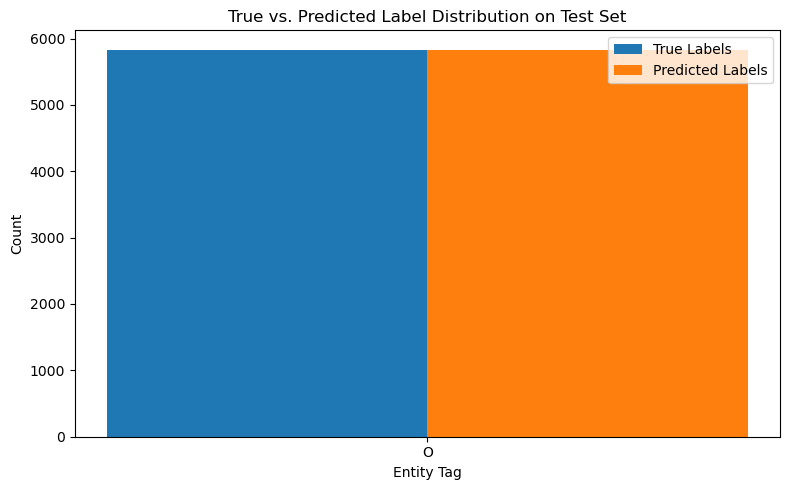

In [48]:
# Create aligned list of all tag types present in either set
true_counter = Counter(flat_trues)
pred_counter = Counter(flat_preds)

# Union of all labels
all_tags = sorted(set(true_counter) | set(pred_counter))
true_counts = [true_counter.get(tag, 0) for tag in all_tags]
pred_counts = [pred_counter.get(tag, 0) for tag in all_tags]

# Plotting
import matplotlib.pyplot as plt
x = range(len(all_tags))
plt.figure(figsize=(8, 5))
plt.bar(x, true_counts, width=0.4, label='True Labels', align='center')
plt.bar([i + 0.4 for i in x], pred_counts, width=0.4, label='Predicted Labels', align='center')
plt.xticks([i + 0.2 for i in x], all_tags)
plt.xlabel("Entity Tag")
plt.ylabel("Count")
plt.title("True vs. Predicted Label Distribution on Test Set")
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Print individual metrics
precision = precision_score(true_tags, predicted_tags, zero_division=0)
recall = recall_score(true_tags, predicted_tags)
f1 = f1_score(true_tags, predicted_tags)

print(f"Precision: {precision:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1 Score:  {f1:.2%}")

Precision: 0.00%
Recall:    0.00%
F1 Score:  0.00%


In [40]:
# Print full report
print("NER Evaluation on Test Set:")
print("Number of sequences:", len(true_tags))
print("Sample true tags:", true_tags[:2])
print("Sample predicted tags:", predicted_tags[:2])
def has_named_entities(sequences):
    return any(any(tag.startswith("B-") or tag.startswith("I-") for tag in seq) for seq in sequences)
print("True tags contain named entities?", has_named_entities(true_tags))
print("Predicted tags contain named entities?", has_named_entities(predicted_tags))
print("Classification Report:")
if has_named_entities(true_tags) and has_named_entities(predicted_tags):
    print(classification_report(true_tags, predicted_tags))
else:
    print("⚠️ No named entities found in either predictions or ground truth. Nothing to report.")

NER Evaluation on Test Set:
Number of sequences: 5832
Sample true tags: [['O'], ['O']]
Sample predicted tags: [['O'], ['O']]
True tags contain named entities? False
Predicted tags contain named entities? False
Classification Report:
⚠️ No named entities found in either predictions or ground truth. Nothing to report.


### Inference Example

Test the model on a new comment.

In [41]:
test_text = "This new update totally changed the way I see the future of tech!"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [42]:
# Tokenize input and get word ID mapping
encoding = tokenizer(test_text, return_tensors="pt", truncation=True, return_offsets_mapping=True, is_split_into_words=False)
encoding = {k: v.to(device) for k, v in encoding.items()}
offset_mapping = encoding.pop("offset_mapping")

In [43]:
# Run through model
with torch.no_grad():
    outputs = model(**encoding).logits
predictions = torch.argmax(outputs, dim=2).squeeze().tolist()

In [44]:
# Convert to labels, ignoring special tokens
tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())
predicted_labels = []
for token, pred_id in zip(tokens, predictions):
    label = id_to_label[pred_id]
    predicted_labels.append(label)

In [45]:
# Print results
print("Tokens:", tokens)
print("Predicted Labels:", predicted_labels)

Tokens: ['[CLS]', 'This', 'new', 'update', 'totally', 'changed', 'the', 'way', 'I', 'see', 'the', 'future', 'of', 'tech', '!', '[SEP]']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [46]:
# Save dataframes
entity_df.to_csv("../data/entity_df.csv", index=False)
predicted_df = pd.DataFrame({"Token": tokens, "Predicted Label": predicted_labels})
predicted_df.to_csv("../data/predictions.csv", index=False)

---

### Discussion of Baseline Results

The baseline BERT-NER model, trained on video comment data with synthetic labels generated from SpaCy-extracted entities, initially failed to identify named entities during evaluation. This was primarily due to extreme class imbalance, with the majority of tokens labeled as "O" and very few examples containing entity tags like B-ORG or B-PROD.

To address this, the dataset was rebalanced by upsampling entity-rich sequences, ensuring the model was sufficiently exposed to examples containing named entities. While this adjustment improved label diversity in the training set, the model still struggled to generalize — often defaulting to predicting "O" across all tokens. We attempted to address this by excluding all "O" sequences in the `synthetic_labels` field.

These results highlight the limitations of relying solely on keyword-matched synthetic labels and surface-level token embeddings. The baseline model lacks semantic understanding and performs poorly on informal references, spelling variations, or emerging entities not explicitly seen during training.

To overcome these challenges, the extended pipeline integrates Sentence-BERT (S-BERT), which provides rich, context-aware embeddings for entire comment spans. Unlike token-based BERT models, S-BERT captures sentence-level semantics and enables similarity-based matching of unknown mentions to known entity clusters. This helps resolve ambiguities, group variants (e.g., "Apple Vision Pro", "vision headset", "AVP"), and improve recall on entities introduced outside the training data. Combined with unsupervised clustering, S-BERT enhances the model’s ability to detect emerging trends and identify novel or context-dependent entities in noisy, user-generated video comments.
